In [1]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted", 24)
%matplotlib inline

nSmart = pypsa.Network("../../results/smart/current/networks/base_s_27_3H_3H_2045.nc")
# nGas = pypsa.Network("../../results/smart/gas-2045/networks/base_s_27_3H_3H_2045.nc")
# n = pypsa.Network("../../results/smart/gas3/networks/base_s_27_3H_3H_2035.nc")
# nGas = pypsa.Network("../../results/smart/current/networks/base_s_27_3H_3H_2045.nc")
nGas = pypsa.Network("../../results/smart/gas-2045-7/networks/base_s_27_3H_3H_2045.nc")


%load_ext autoreload
%autoreload 2


INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [2]:
from pea import Pea, carriers as cs
import seaborn as sns
colors = sns.color_palette("Spectral", 20)  # 生成 20 种颜色

peas = {
  # 'Gas': Pea(nGas, config= {'resolution': 3}),
  'Smart': Pea(nSmart, config= {'resolution': 3})
}

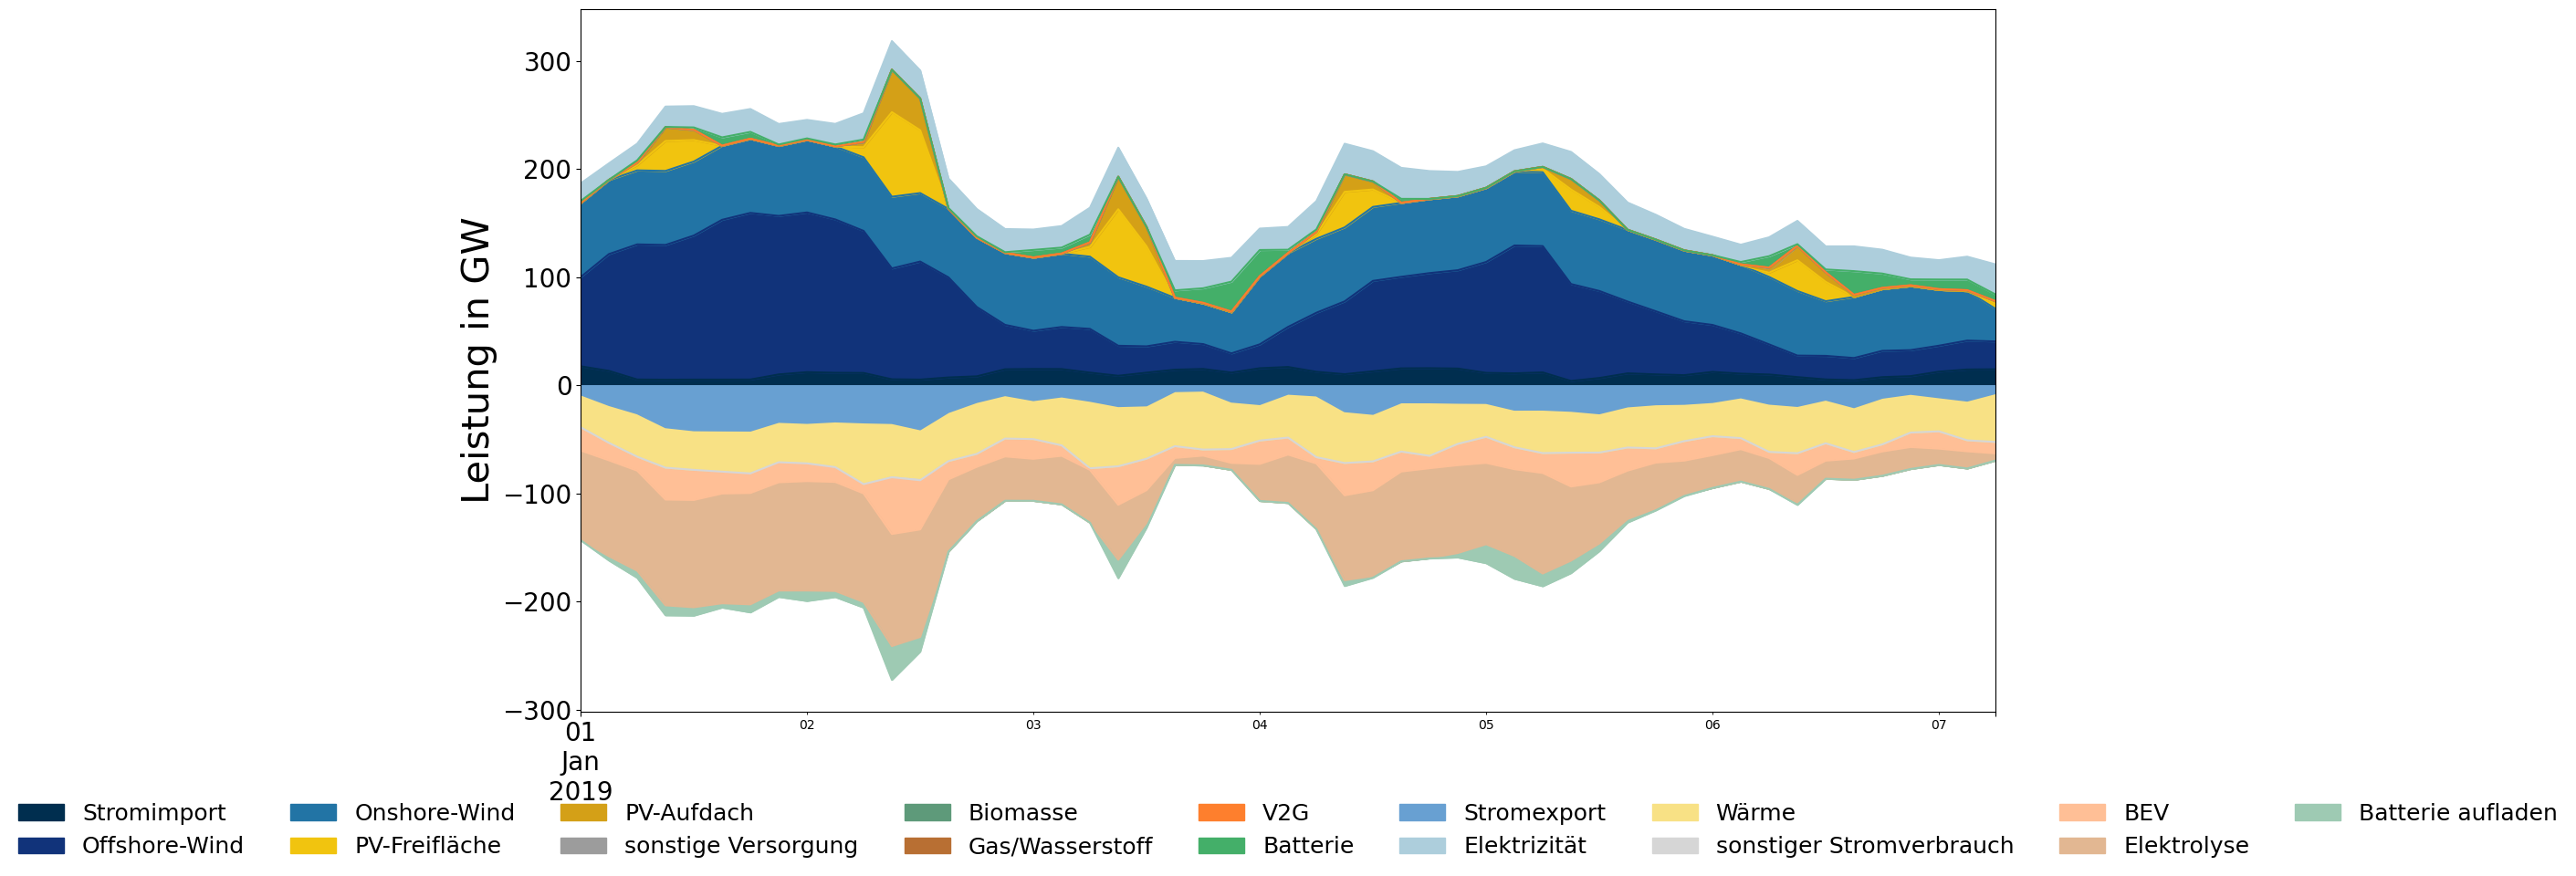

333 Index(['Stromimport', 'Offshore-Wind', 'Onshore-Wind', 'PV-Freifläche',
       'PV-Aufdach', 'sonstige Versorgung', 'Biomasse', 'Gas/Wasserstoff',
       'V2G', 'Batterie', 'Stromexport', 'Elektrizität', 'Wärme',
       'sonstiger Stromverbrauch', 'BEV', 'Elektrolyse', 'Batterie aufladen'],
      dtype='object')
Stromimport                  96.306389
Offshore-Wind               361.327258
Onshore-Wind                409.265038
PV-Freifläche               319.507566
PV-Aufdach                  156.760050
sonstige Versorgung           3.010032
Biomasse                      1.204068
Gas/Wasserstoff               0.369980
V2G                          39.668789
Batterie                     64.130692
Stromexport                -154.708273
Elektrizität                206.000689
Wärme                      -207.069094
sonstiger Stromverbrauch     -4.013346
BEV                        -206.061645
Elektrolyse                -715.368862
Batterie aufladen           -66.802804
dtype: float64


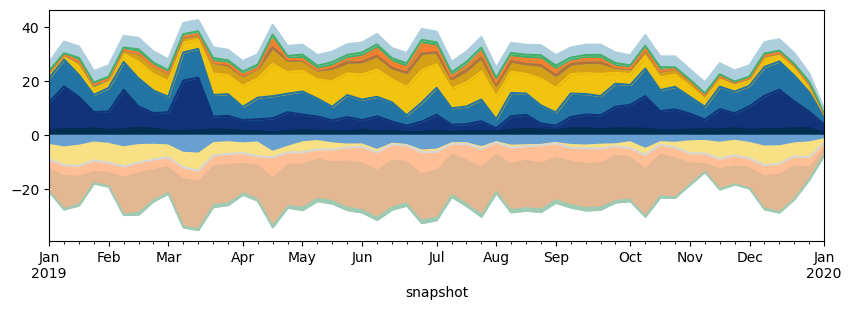

In [ ]:

pTotal = pd.DataFrame()

for key, pea in peas.items():

  pea = peas[key]
  df = pd.DataFrame(index = nGas.snapshots)

  for carrier in ['onwind', 'offwind', 'solar', 'solarRooftop']:
    df[carrier] = pea.get(getattr(cs,carrier)).t('p').sum(axis=1)

  for carrier in ['batteryDischarger', 'gasH2Power', 'biomassCHP', 'geothermalORC', 'v2g', 'h2FC']:
    carrier_t = pea.get(getattr(cs,carrier)).t('p', pAs='p1')
    if carrier_t is not None:
      df[carrier] = - carrier_t.sum(axis=1)
  df['phs'] = pea.get(cs.phs).t('p_dispatch').sum(axis=1)
  df['importPower'] = - pea.get(cs.power, type='import').t('p1').clip(upper=0).sum(axis=1) \
                      - pea.get(cs.power, type='export').t('p0').clip(upper=0).sum(axis=1)
  df['importPower'] = - pea.get(cs.power, type='export').t('p0').clip(upper=0).sum(axis=1)


  df['otherSupply'] = df[['phs',  'geothermalORC', 'h2FC']].sum(axis=1)
  df = df.drop(columns=['phs',  'geothermalORC', 'h2FC'])

  df['powerUse'] = - pea.get(cs.powerUse).t('p').sum(axis=1)
  for carrier in ['h2Electrolysis', 'batteryCharger', 'power2warm', 'bevCharger']:
    carrier_t = pea.get(getattr(cs,carrier)).t('p', pAs='p0')
    if carrier_t is not None:
      df[carrier] = - pea.get(getattr(cs,carrier)).t('p', pAs='p0').sum(axis=1)

  df['exportPower'] = - pea.get(cs.power, type='import').t('p1').clip(lower=0).sum(axis=1) \
                      - pea.get(cs.power, type='export').t('p0').clip(lower=0).sum(axis=1)
  df['otherUse'] = - pea.get(cs.phs).t('p_store').sum(axis=1)
  desired_columns = ['importPower', 'onwind', 'offwind', 'solar', 'solarRooftop', 'otherSupply',  'biomassCHP', 'gasH2Power'
           ,'v2g', 'batteryDischarger',
            'exportPower','powerUse', 'power2warm', 'otherUse',  'bevCharger','h2Electrolysis'
            ,'batteryCharger'
          ]
  df = df[[col for col in desired_columns if col in df.columns]]
  
  df = df.rename(columns= cs.mapName)
  df = df / 1e3
  ax = df['2019-1-1 0:00:00': '2019-1-7 6:00:00'].plot(kind='area', figsize=(20,10),color=cs.mapNameColor, legend=True)
  ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False,fontsize=18)
  # ax.xaxis.set_major_formatter(DateFormatter(" %d %m"))
  ax.set_ylabel('Leistung in GW',fontsize=30)
  ax.set_xlabel('')
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.grid(False)
  plt.show()

  df = df / 1e3 * 3
  df.resample('W').sum().plot(kind='area', figsize=(10,3),color=cs.mapNameColor, legend= False)
  df = df.sum()
  print(333, df.index)
  if ('V2G' not in df.index):
    print(333)
    df['V2G'] =0
  print(df)
  pTotal[key] = df




                          Gas     Smart
Stromimport         171.97831  71.55123
Offshore-Wind       146.39655  56.44781
Onshore-Wind        417.55355 221.05954
PV-Freifläche        47.50337  34.56216
PV-Aufdach          146.77569  77.32210
sonstige Versorgung   8.37050   0.96938
Biomasse              8.61237   1.56228
Gas/Wasserstoff       3.05329   4.04456
V2G                   0.00000   7.20684
       Stromimport  Offshore-Wind  Onshore-Wind  PV-Freifläche  PV-Aufdach  sonstige Versorgung  Biomasse  Gas/Wasserstoff     V2G
Gas      171.97831      146.39655     417.55355       47.50337   146.77569              8.37050   8.61237          3.05329 0.00000
Smart     71.55123       56.44781     221.05954       34.56216    77.32210              0.96938   1.56228          4.04456 7.20684


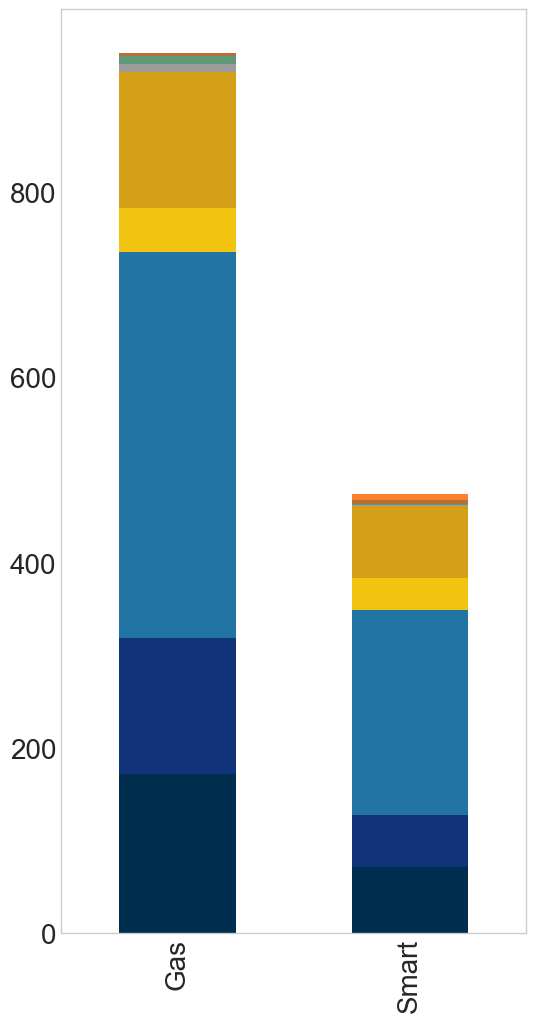

In [513]:
pTotalG = pTotal[(pTotal['Smart'] >= 0) & (pTotal['Gas'] >= 0)]  
print(pTotalG)
# pTotalG = pTotalG.sort_values(by='Gas', ascending=True)
# desired_columns = ['importPower', 'onwind', 'offwind', 'solar', 'solarRooftop', 'otherSupply',  'biomassCHP', 'gasH2Power'
#            ,'v2g', 'batteryDischarger',
#           ]
# pTotalG = pTotalG[[col for col in desired_columns if col in pTotalG.columns]]
# pTotalG = pTotal
pTotalG = pTotalG.T
pTotalG.plot(kind='bar', color= cs.mapNameColor, legend= None, figsize=(6,12), stacked=True)
plt.grid(False)

ax.set_ylabel('')
ax.set_ylabel('Kapazität in GW',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
print(pTotalG)


7241.830547306426
7241.824439801781
                         Gas    Smart
Stromimport          35.0388  34.3052
Offshore-Wind        74.0688  53.8606
Onshore-Wind         78.3288  78.3288
PV-Freifläche        50.8788  68.2345
PV-Aufdach          164.6851 164.6852
sonstige Versorgung   7.2418   7.2418
Biomasse              7.2039   2.6137
Gas/Wasserstoff     141.9553  81.8412
Batterie                 NaN  25.3617


NameError: name 'ax' is not defined

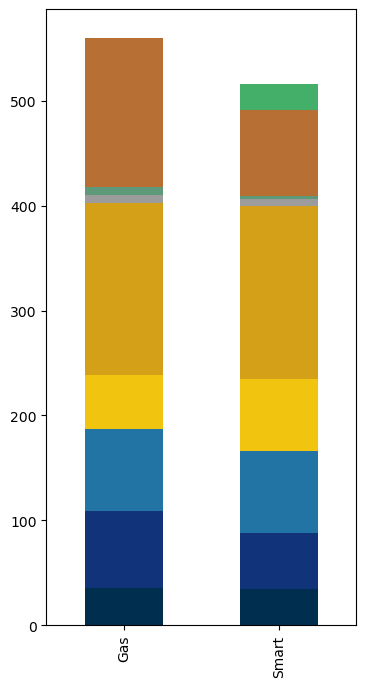

In [4]:
pNomOpt = pd.DataFrame()

for key, pea in peas.items():

  df = pd.Series()
  for carrier in ['onwind', 'offwind', 'solar', 'solarRooftop']:
    df[carrier] = pea.get(getattr(cs,carrier)).df['p_nom_opt'].sum()

  for carrier in ['batteryDischarger', 'gasH2Power', 'biomassCHP', 'geothermalORC', 'v2g', 'h2FC']:
    carrierDf = pea.get(getattr(cs,carrier)).df
    if carrierDf is not None:
      df[carrier]= carrierDf['p_nom_opt'].sum()
  
  df['phs'] = pea.get(cs.phs).df['p_nom_opt'].sum()

  df['otherSupply'] = df[['phs',  'geothermalORC', 'h2FC']].sum()
  print(df['otherSupply'])
  df = df.drop(['phs',  'geothermalORC', 'h2FC',
               
                ])

  df['importPower'] = pea.get(cs.power, type='import').importP().sum(axis=1).max()

  # df['powerUse'] = - pea.get(cs.powerUse).t('p').sum(axis=1).max()
  # for carrier in ['h2Electrolysis', 'batteryCharger', 'power2warm', 'bevCharger', 'powerUse']:
  #   carrierT = pea.get(getattr(cs,carrier)).t('p', pAs='p0')
  #   if carrierT is not None:
  #     df[carrier]= - carrierT.sum(axis=1).max()
      
  # df['exportPower'] = -pea.get(cs.power, type='export').exportP().sum(axis=1).max()
  # df['otherUse'] = - pea.get(cs.phs).df['p_nom_opt'].sum()

  df = df/ 1e3
  df = df.reindex(['importPower', 'onwind', 'offwind', 'solar', 'solarRooftop', 'otherSupply',  'biomassCHP', 'gasH2Power'
           , 'batteryDischarger',
          ])
  df = df.rename(index=cs.mapName)

  pNomOpt[key] = df

pd.set_option('display.float_format', '{:.4f}'.format)
pNomOptG = pNomOpt
# pNomOptG = pNomOpt[(pNomOpt['Gas'] >= 0) & (pNomOpt['Smart'] >= 0)]
print(pNomOptG)
pNomOptG = pNomOptG.T
pNomOptG.plot(kind='bar',   figsize=(4,8), stacked=True, color=cs.mapNameColor, legend=False)

plt.grid(False)
ax.set_ylabel('')
ax.set_xlabel('Kapazität in GW',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [501]:
pea = Pea(nSmart, config= {'resolution': 3})

for carrier in ['onwind','offwind-ac', 'offwind-dc', 'offwind-float', 'solar', 'solar rooftop']:
  min = pea.get(carrier).p_nom_opt() * 0.99
  max = pea.get(carrier).p_nom_opt() * 1.01
  print(carrier, min, max)


pea.get(cs.battery).df['e_nom_opt'].sum() / 1e3

onwind 72594.85893965117 74061.42174651282
offwind-ac 12468.584702596767 12720.475302649225
offwind-dc 64403.97557966079 65705.06599541151
offwind-float 523.3492148873935 533.92192629926
solar 49784.30805451069 50790.05165157151
solar rooftop 163038.36053356022 166332.06478676345


28.042645258867548

In [494]:
import myUtils as utils

dict = {
  'capex': nGas.statistics.capex().sum() /1e9,
  'opx': nGas.statistics.opex(groupby=utils.de_grouper).sum() /1e9,
  'cap': nGas.statistics.capex(groupby=utils.de_grouper).sum() /1e9,
}

AttributeError: module 'pypsa.statistics' has no attribute 'groupers'

In [ ]:
nSmart